I'll provide a concise overview of recommender systems and their main types.

Recommender systems are machine learning algorithms that suggest relevant items to users based on patterns in data. They're used extensively by companies like Netflix, Amazon, and Spotify to suggest content, products, and music.

Here are the main types:

1. Collaborative Filtering
   - User-Based: Recommends items based on preferences of similar users
   - Item-Based: Recommends items similar to ones the user already likes
   - Advantages: Works well with user preference data
   - Disadvantages: Cold start problem for new users/items

2. Content-Based Filtering
   - Uses item features/attributes to make recommendations
   - Example: Recommending movies based on genre, actors, director
   - Advantages: No cold start problem for items
   - Disadvantages: Limited to known item features

3. Hybrid Recommender Systems
   - Combines multiple approaches
   - Can overcome limitations of individual methods
   - Example: Netflix combines viewing history (collaborative) with content features (content-based)

4. Knowledge-Based
   - Uses explicit rules and domain knowledge
   - Good for complex items like cars or houses
   - Advantages: Works well for infrequently purchased items

5. Context-Aware
   - Considers situational context (time, location, device)
   - Example: Recommending restaurants based on time of day and location

Would you like me to elaborate on any of these types or explain specific algorithms used within them?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catppuccin
import matplotlib as mpl
mpl.style.use(catppuccin.PALETTE.mocha.identifier)

from sklearn.metrics.pairwise import cosine_similarity


![cos](https://kdb.ai/files/2024/01/similarity-768x348.png)

In [3]:
path = '/Users/bassel_instructor/Documents/Datasets/'
df = pd.read_csv(path+'rating.csv')
df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


<Axes: xlabel='rating', ylabel='count'>

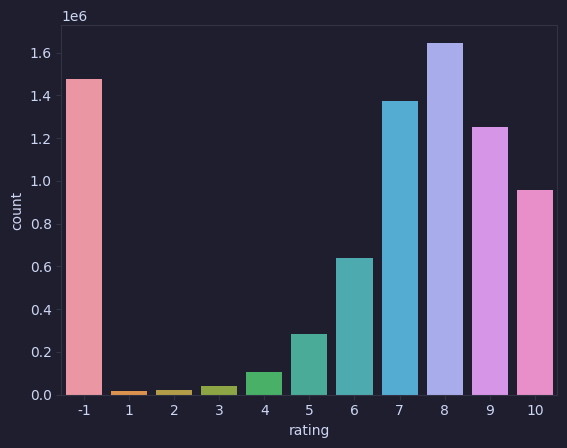

In [4]:
sns.countplot(data=df, x='rating')

In [5]:
# Exclude rows where the rating is -1 (implying missing or few ratings from individuals)
df = df[df['rating'] != -1]
df.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


<Axes: xlabel='rating', ylabel='count'>

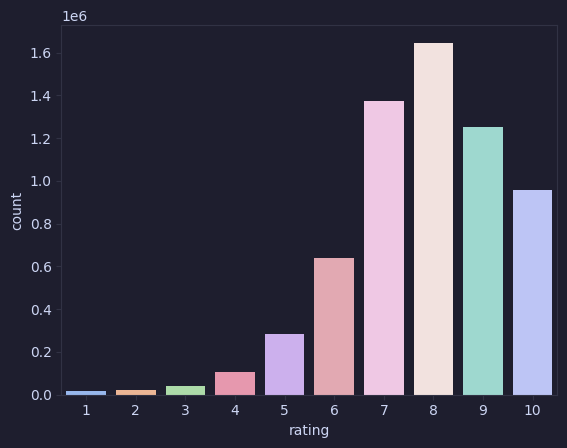

In [6]:
sns.countplot(data=df, x='rating')

In [7]:
df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [8]:
df.shape

(6337241, 3)

In [9]:
# Calculate the number of unique user IDs in the filtered ratings dataset
len(df['user_id'].unique())

69600

In [10]:
# Calculate the number of unique anime IDs in the 'animes' dataset
len(df['anime_id'].unique())

9927

In [11]:
# Calculate the number of ratings per user
ratings_per_user = df.groupby('user_id')[['rating']].count()
ratings_per_user.head()

,rating
user_id,
1,4
2,1
3,92
5,459
7,343


In [12]:
# Calculate the mean number of ratings per user
ratings_per_user.mean()

rating    91.052313
dtype: float64

__Observations:__
- The average user has rated about 91 items, indicating a moderately active engagement in rating items within the dataset.
- With an average of 91 ratings per user, the dataset shows a balance of user activity that is not skewed by extremely active users.

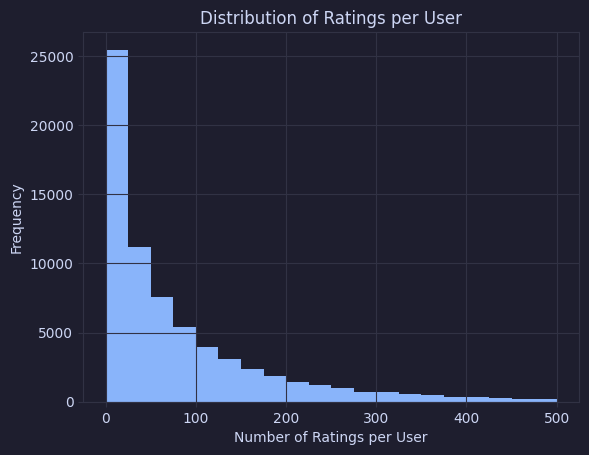

In [13]:
#Plot a histogram of the number of ratings per user
ratings_per_user.hist(bins=20, range=(0,500))
plt.xlabel('Number of Ratings per User')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings per User')
plt.show()

<Axes: xlabel='rating'>

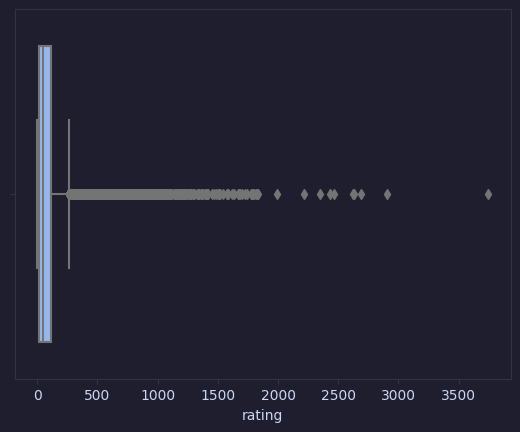

In [14]:
sns.boxplot(x=ratings_per_user['rating'])

__Observations:__
- The histogram displays a right-skewed distribution, indicating that most users have rated fewer than 100 items.
- A very small number of users have rated between 100 and 500 items, with the frequency decreasing as the number of ratings increases.
- As shown by the bars approaching zero frequency, users providing a high number of ratings are exceedingly rare.

In [15]:
# Calculate the number of ratings per anime
ratings_per_anime = df.groupby('anime_id')[['rating']].count()

# Calculate the mean number of ratings per anime
ratings_per_anime.mean()

rating    638.384305
dtype: float64

__Observations:__
- On average, each anime title receives approximately 638 ratings, which implies a diverse range of viewer engagement levels.
- The mean of 638 ratings per anime suggests that while some receive more attention, many others have far fewer ratings.

Text(0.5, 1.0, 'Distribution of Ratings per Anime')

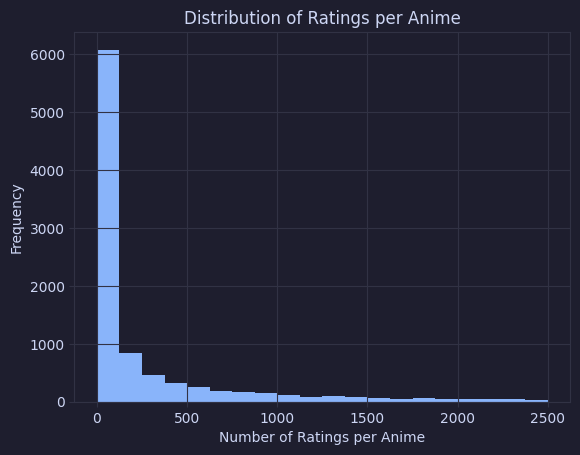

In [16]:
import matplotlib.pyplot as plt

# Plot a histogram of the number of ratings per anime
ratings_per_anime.hist(bins=20, range=(0,2500))
plt.xlabel('Number of Ratings per Anime')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings per Anime')

__Observations:__
- The highest frequency of anime titles has between 0 and 250 ratings, as depicted by the first bar in the histogram.
- Very few anime titles receive more than 1500 ratings, highlighting a significant drop-off in frequency as the number of ratings increases.

Filter ratings greater than 1000 to find a popular anime and extract the anime IDs of popular anime.

In [17]:
# Filter the DataFrame to include only anime with 1000 or more ratings
filtered_ratings_per_anime_df = ratings_per_anime[ratings_per_anime['rating'] >= 1000]
filtered_ratings_per_anime_df.shape

(1462, 1)

In [18]:
# Extract the indices (anime IDs) of popular anime
popular_anime = filtered_ratings_per_anime_df.index.tolist()
popular_anime[:20]

[1, 5, 6, 7, 15, 16, 18, 19, 20, 22, 24, 25, 26, 27, 28, 30, 31, 32, 33, 43]

Filter ratings greater than 500 and create an index to list prolific users.

In [19]:
# Filter the DataFrame to include only users with 500 or more ratings
filtered_ratings_per_user_df = ratings_per_user[ratings_per_user.rating >= 500]
filtered_ratings_per_user_df.shape

(1365, 1)

In [20]:

# Extract the indices (user IDs) of prolific users
prolific_users = filtered_ratings_per_user_df.index.tolist()
prolific_users[:10]

[226, 271, 294, 392, 446, 478, 661, 741, 771, 786]

In [21]:
# Filter the ratings dataset to include only ratings for popular anime
filtered_ratings = df[df['anime_id'].isin(popular_anime)]
print(f'{len(filtered_ratings):,}')

5,192,794


In [22]:

# Further filter the ratings dataset to include only ratings from prolific users
filtered_ratings = df[df['user_id'].isin(prolific_users)]

# Calculate the length of the filtered ratings dataset
print(f'{len(filtered_ratings):,}')

1,005,314


In [27]:
# Create a pivot table to construct the user-item rating matrix
rating_matrix = filtered_ratings.pivot_table(index='user_id', columns='anime_id', values='rating', fill_value=0)

# or Fill missing values (NaN) with 0
#rating_matrix = rating_matrix.fillna(0)

# Display the first few rows of the user-item rating matrix
rating_matrix.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,34238,34239,34240,34252,34283,34324,34325,34349,34367,34475
user_id,,,,,,,,,,,,,,,,,,,,,
226,8,0,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271,0,0,0,0,0,0,0,0,0,0,...,0,0,10,0,0,0,0,0,0,0
294,7,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
392,7,0,7,0,0,0,0,0,7,0,...,0,0,0,0,0,0,0,0,0,0
446,9,8,9,0,0,0,0,0,0,10,...,0,0,9,0,0,0,0,0,0,0


Make sure your rating on a scale that starts from 1 so you can use 0 to replace missing values

In [29]:

# Compute cosine similarity between users
user_similarity = cosine_similarity(rating_matrix)
user_similarity

array([[1.        , 0.31052381, 0.36980954, ..., 0.36236069, 0.33636818,
        0.30650698],
       [0.31052381, 1.        , 0.268366  , ..., 0.290322  , 0.2870974 ,
        0.22791986],
       [0.36980954, 0.268366  , 1.        , ..., 0.3498557 , 0.41170536,
        0.37794637],
       ...,
       [0.36236069, 0.290322  , 0.3498557 , ..., 1.        , 0.34721124,
        0.31961904],
       [0.33636818, 0.2870974 , 0.41170536, ..., 0.34721124, 1.        ,
        0.42175493],
       [0.30650698, 0.22791986, 0.37794637, ..., 0.31961904, 0.42175493,
        1.        ]])

In [30]:
# Convert to a DataFrame for easier manipulation and interpretation
user_similarity_df = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)
user_similarity_df

user_id,226,271,294,392,446,478,661,741,771,786,...,73234,73272,73286,73340,73356,73362,73378,73395,73499,73502
user_id,,,,,,,,,,,,,,,,,,,,,
226,1.000000,0.310524,0.369810,0.368844,0.479172,0.351496,0.339471,0.453386,0.397297,0.384594,...,0.290858,0.362299,0.413587,0.434253,0.309391,0.288167,0.453607,0.362361,0.336368,0.306507
271,0.310524,1.000000,0.268366,0.221096,0.342823,0.376454,0.306231,0.345585,0.357868,0.493646,...,0.272166,0.159041,0.307801,0.289110,0.096752,0.346684,0.357435,0.290322,0.287097,0.227920
294,0.369810,0.268366,1.000000,0.358606,0.387980,0.394491,0.360027,0.419455,0.361109,0.470477,...,0.361611,0.282967,0.362801,0.413025,0.353574,0.340823,0.451359,0.349856,0.411705,0.377946
392,0.368844,0.221096,0.358606,1.000000,0.397043,0.307310,0.293243,0.316196,0.396577,0.314374,...,0.286049,0.340013,0.342345,0.465727,0.322202,0.266032,0.434801,0.360945,0.304120,0.242900
446,0.479172,0.342823,0.387980,0.397043,1.000000,0.377938,0.405816,0.430414,0.404201,0.430761,...,0.357724,0.353429,0.402775,0.431481,0.314192,0.292046,0.481478,0.401871,0.340195,0.335937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73362,0.288167,0.346684,0.340823,0.266032,0.292046,0.450861,0.272566,0.358541,0.437512,0.412681,...,0.334768,0.207235,0.350239,0.349987,0.238223,1.000000,0.396227,0.318946,0.332661,0.355931
73378,0.453607,0.357435,0.451359,0.434801,0.481478,0.465542,0.359494,0.462871,0.504422,0.487243,...,0.431488,0.297537,0.450135,0.470631,0.343550,0.396227,1.000000,0.439854,0.456134,0.454755
73395,0.362361,0.290322,0.349856,0.360945,0.401871,0.404292,0.332429,0.377932,0.367900,0.397738,...,0.366442,0.264322,0.403430,0.380225,0.244898,0.318946,0.439854,1.000000,0.347211,0.319619


For ease of use, we'll build a function that derives the recommendation from the user cosine similarity matrix

In [31]:

# Function to recommend anime based on similar users
def recommend_anime(user_id, user_item_matrix, user_similarity_df, top_n=5):
    # Get the user's ratings
    user_ratings = user_item_matrix.loc[user_id]

    # Find similar users based on cosine similarity
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)
    
    # Store anime recommendations
    recommendations = pd.Series(dtype='float64')
    
    for similar_user in similar_users.index[1:]:  # Skip the first one as it's the user themselves
        # Get ratings of the similar user
        similar_user_ratings = user_item_matrix.loc[similar_user]
        
        # Find the anime the similar user has rated but the current user hasn't
        recommended_anime = similar_user_ratings[similar_user_ratings > 0].index.difference(user_ratings[user_ratings > 0].index)
        
        # Append those anime to the recommendations
        recommendations = pd.concat([recommendations, similar_user_ratings.loc[recommended_anime]])

    # Sort recommendations by rating and return the top N
    recommendations = recommendations.sort_values(ascending=False).drop_duplicates()
    return recommendations.head(top_n)


In [39]:
user_similarity_df.sample(20).index[:20]

Index([60171, 23715, 18683, 66024, 73286, 50625, 45097, 11250,  3657, 49520,
        5504, 50671,   271, 73188, 32167, 34466, 37923, 17887, 57082, 69076],
      dtype='int64', name='user_id')

In [34]:

# Example usage:
user_id = 226
recommended_anime = recommend_anime(user_id, rating_matrix, user_similarity_df)
print(f"Anime recommendations for user {user_id}:")
print(recommended_anime)


Anime recommendations for user 226:
24031    10
6964      9
31964     8
6951      7
654       6
dtype: int64


In [40]:

# Example usage:
user_id = 50671
recommended_anime = recommend_anime(user_id, rating_matrix, user_similarity_df)
print(f"Anime recommendations for user {user_id}:")
print(recommended_anime)


Anime recommendations for user 50671:
181      10
31964     9
10216     8
32802     7
9624      6
dtype: int64


The results you provided suggest a list of recommended anime for **User 50671**, along with the predicted ratings for each one. Here's how to interpret these recommendations:

### 1. **Understanding the Recommendations**:
   - **Anime ID 181 with a rating of 10**: This means that the recommendation system predicts that User 50671 would rate Anime ID 181 as a **10/10**, suggesting it’s a top recommendation for this user.
   - **Anime ID 31964 with a rating of 9**: This anime is likely to be highly enjoyable to the user, with a predicted rating of **9/10**.
   - **Anime ID 10216 with a rating of 8**: The system believes the user would rate this anime as an **8/10**, meaning they would still likely enjoy it.
   - **Anime ID 32802 with a rating of 7**: The user may find this anime enjoyable but not exceptional, based on a predicted rating of **7/10**.
   - **Anime ID 9624 with a rating of 6**: This anime is predicted to be just okay for the user, with a rating of **6/10**.

### 2. **How the Recommendations Are Ranked**:
   - The recommendations are sorted by **predicted user ratings**, with higher predicted ratings indicating the anime that the system believes the user would like the most.
   - In this case, **Anime ID 181** is the most highly recommended for User 50671, followed by Anime IDs 31964, 10216, etc.

### 3. **Predicted Rating Meaning**:
   - **10 (for Anime 181)**: This anime is predicted to be a perfect match for the user’s tastes, similar to anime the user has highly rated in the past or similar to anime rated highly by other similar users.
   - **9, 8, 7, 6**: These represent slightly lower predicted ratings but still suggest that the user will likely enjoy these anime. The rating reflects the confidence the system has in how much the user will enjoy each one.


In [41]:
df_anime = pd.read_csv(path+'anime.csv')
df_anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [47]:
print(f"Recommended items for user {user_id}:\n {df_anime[df_anime['anime_id'].isin(recommended_anime.index)]['name']}")

Recommended items for user 50671:
 178                       Boku no Hero Academia
1198             Yondemasu yo, Azazel-san. (TV)
1461                 Vandread: The Second Stage
2869    Cardfight!! Vanguard G: Stride Gate-hen
3931                     30-sai no Hoken Taiiku
Name: name, dtype: object



### 4. **Recommendations for Action**:
   - **Watchlist**: The user can prioritize anime with higher predicted ratings (e.g., Anime ID 181 and 31964) for their watchlist.
   - **Exploration**: Lower-rated recommendations, like Anime ID 9624 with a predicted rating of 6, could still be worth exploring, but they may not align as closely with the user’s typical preferences.

### 5. **Possible Improvements**:
   - **Filtering by minimum rating**: If User 50671 only wants to see highly recommended shows, you might filter out anime with predicted ratings below a certain threshold (e.g., 7 or 8).
   - **Explore genres**: Consider adding genre filtering or weighting to better tailor the recommendations based on the user's favorite genres.

### Final Thoughts:
The results provide a clear picture of anime that the system thinks User 50671 will enjoy based on the preferences of other similar users. The higher the predicted rating, the more confident the system is that the user will like that particular anime.

Would you like help with adding more filters or adjusting the recommendation algorithm further?